In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
import tensorflow as tf
from sklearn.feature_selection import SelectKBest, chi2, f_regression

In [2]:
data=pd.read_csv('propulsion.csv')

# Data cleaning

In [3]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
#renaming columns
data.columns
data.columns = ['lever_position', 'ship_speed', 'gt_shaft', 'gt_rate',
                     'gg_rate', 'sp_torque', 'pp_torque', 'hpt_temp',
                     'gt_c_i_temp', 'gt_c_o_temp', 'hpt_pressure',
                     'gt_c_i_pressure', 'gt_c_o_pressure',
                     'gt_exhaust_pressure', 'turbine_inj_control', 'fuel_flow',
                     'gt_c_decay',  'gt_t_decay']

In [5]:
#checking for misssing values
data.isnull().sum()

lever_position         0
ship_speed             0
gt_shaft               0
gt_rate                0
gg_rate                0
sp_torque              0
pp_torque              0
hpt_temp               0
gt_c_i_temp            0
gt_c_o_temp            0
hpt_pressure           0
gt_c_i_pressure        0
gt_c_o_pressure        0
gt_exhaust_pressure    0
turbine_inj_control    0
fuel_flow              0
gt_c_decay             0
gt_t_decay             0
dtype: int64

In [6]:
#dropping two constant value columns GT compressor inlet air temperature and 
#GT compressor inlet air pressure
data.drop(['gt_c_i_temp', 'gt_c_i_pressure'], axis=1 ,inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lever_position       10000 non-null  float64
 1   ship_speed           10000 non-null  float64
 2   gt_shaft             10000 non-null  float64
 3   gt_rate              10000 non-null  float64
 4   gg_rate              10000 non-null  float64
 5   sp_torque            10000 non-null  float64
 6   pp_torque            10000 non-null  float64
 7   hpt_temp             10000 non-null  float64
 8   gt_c_o_temp          10000 non-null  float64
 9   hpt_pressure         10000 non-null  float64
 10  gt_c_o_pressure      10000 non-null  float64
 11  gt_exhaust_pressure  10000 non-null  float64
 12  turbine_inj_control  10000 non-null  float64
 13  fuel_flow            10000 non-null  float64
 14  gt_c_decay           10000 non-null  float64
 15  gt_t_decay           10000 non-null  

In [8]:
data.describe()

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_o_temp,hpt_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.150075,14.951400,27100.647714,2131.151788,8194.182366,225.957785,225.957785,734.476178,645.748980,2.345732,12.262597,1.029402,33.480715,0.659100,0.975021,0.987455
std,2.624015,7.740467,22062.780307,772.211732,1090.569425,199.737886,199.737886,173.009157,72.483036,1.081038,5.320817,0.010353,25.721725,0.504791,0.014734,0.007510
min,1.138000,3.000000,253.547000,1307.675000,6589.002000,5.304000,5.304000,444.731000,540.999000,1.093000,5.828000,1.019000,0.000000,0.068000,0.950000,0.975000
25%,3.144000,9.000000,8375.791500,1386.758000,7056.520500,60.317000,60.317000,589.841000,577.980750,1.389000,7.445000,1.020000,13.534000,0.246000,0.962000,0.981000
50%,5.140000,15.000000,21630.133500,1924.325000,8480.527000,175.264000,175.264000,705.351000,636.800000,2.082000,11.086000,1.026000,25.249500,0.496000,0.975000,0.987000
75%,7.148000,21.000000,39000.710250,2678.078000,9132.132500,332.360000,332.360000,833.154750,693.656750,2.981000,15.649000,1.036000,44.500000,0.881000,0.988000,0.994000
max,9.300000,27.000000,72783.338000,3560.741000,9797.103000,645.249000,645.249000,1115.797000,789.094000,4.560000,23.140000,1.052000,92.556000,1.832000,1.000000,1.000000


In [9]:
data.corr('pearson')

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_o_temp,hpt_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
lever_position,1.000000,0.999915,0.960911,0.961725,0.986055,0.959239,0.959239,0.960749,0.982576,0.962875,0.968923,0.953182,0.912612,0.931016,-0.002070,-0.001045
ship_speed,0.999915,1.000000,0.958136,0.960055,0.986651,0.956379,0.956379,0.958342,0.980985,0.960437,0.966792,0.950647,0.908985,0.927413,-0.002009,-0.001008
gt_shaft,0.960911,0.958136,1.000000,0.989663,0.933165,0.999170,0.999170,0.991094,0.990291,0.998888,0.997574,0.996014,0.977424,0.995014,0.000736,-0.000533
gt_rate,0.961725,0.960055,0.989663,1.000000,0.942944,0.988572,0.988572,0.979419,0.989157,0.995086,0.996008,0.994047,0.961876,0.980114,0.000156,-0.000677
gg_rate,0.986055,0.986651,0.933165,0.942944,1.000000,0.929888,0.929888,0.939507,0.966665,0.937563,0.946019,0.924375,0.878552,0.896886,-0.020852,0.008703
sp_torque,0.959239,0.956379,0.999170,0.988572,0.929888,1.000000,1.000000,0.985895,0.987468,0.997996,0.996165,0.996190,0.976964,0.994254,-0.001594,-0.000669
pp_torque,0.959239,0.956379,0.999170,0.988572,0.929888,1.000000,1.000000,0.985895,0.987468,0.997996,0.996165,0.996190,0.976964,0.994254,-0.001594,-0.000669
hpt_temp,0.960749,0.958342,0.991094,0.979419,0.939507,0.985895,0.985895,1.000000,0.992211,0.989299,0.990364,0.979985,0.969290,0.986324,-0.041719,-0.039901
gt_c_o_temp,0.982576,0.980985,0.990291,0.989157,0.966665,0.987468,0.987468,0.992211,1.000000,0.991726,0.994381,0.983489,0.958245,0.976426,-0.049096,-0.018060
hpt_pressure,0.962875,0.960437,0.998888,0.995086,0.937563,0.997996,0.997996,0.989299,0.991726,1.000000,0.999401,0.997941,0.975268,0.992656,0.006266,-0.003528


In [10]:
data.corr('spearman')

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_o_temp,hpt_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
lever_position,1.000000,1.000000,0.988817,0.971524,0.993709,0.993805,0.993805,0.969018,0.988198,0.989144,0.988856,0.991290,0.929538,0.974262,-0.002028,-0.001022
ship_speed,1.000000,1.000000,0.988817,0.971524,0.993709,0.993805,0.993805,0.969018,0.988198,0.989144,0.988856,0.991290,0.929538,0.974262,-0.002028,-0.001022
gt_shaft,0.988817,0.988817,1.000000,0.972583,0.988282,0.990411,0.990411,0.982898,0.993709,0.984468,0.986637,0.980582,0.928845,0.984774,-0.042818,0.024251
gt_rate,0.971524,0.971524,0.972583,1.000000,0.976379,0.978221,0.978221,0.955832,0.972033,0.960471,0.961879,0.970931,0.885985,0.956051,-0.051914,0.039146
gg_rate,0.993709,0.993709,0.988282,0.976379,1.000000,0.992472,0.992472,0.967071,0.990252,0.973153,0.975942,0.979514,0.923373,0.970208,-0.100099,0.045970
sp_torque,0.993805,0.993805,0.990411,0.978221,0.992472,1.000000,1.000000,0.963954,0.985535,0.979849,0.981120,0.986069,0.911267,0.967947,-0.031250,0.015754
pp_torque,0.993805,0.993805,0.990411,0.978221,0.992472,1.000000,1.000000,0.963954,0.985535,0.979849,0.981120,0.986069,0.911267,0.967947,-0.031250,0.015754
hpt_temp,0.969018,0.969018,0.982898,0.955832,0.967071,0.963954,0.963954,1.000000,0.990345,0.975200,0.984113,0.958654,0.948439,0.998878,-0.073562,-0.064580
gt_c_o_temp,0.988198,0.988198,0.993709,0.972033,0.990252,0.985535,0.985535,0.990345,1.000000,0.982102,0.989699,0.973646,0.937075,0.991525,-0.095368,-0.032288
hpt_pressure,0.989144,0.989144,0.984468,0.960471,0.973153,0.979849,0.979849,0.975200,0.982102,1.000000,0.996419,0.988613,0.921780,0.979578,0.084757,-0.036081


# Visualizations

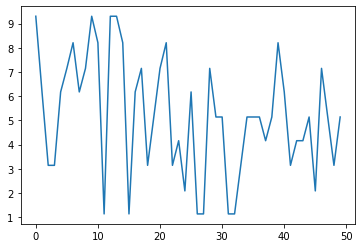

In [11]:
data['lever_position'].iloc[0:50].plot()

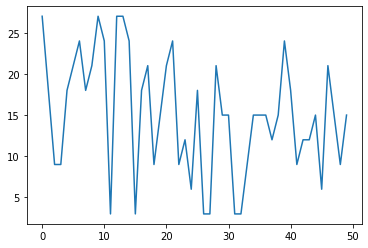

In [12]:
data['ship_speed'].iloc[0:50].plot()

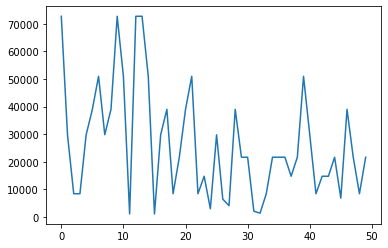

In [13]:
data['gt_shaft'].iloc[0:50].plot()

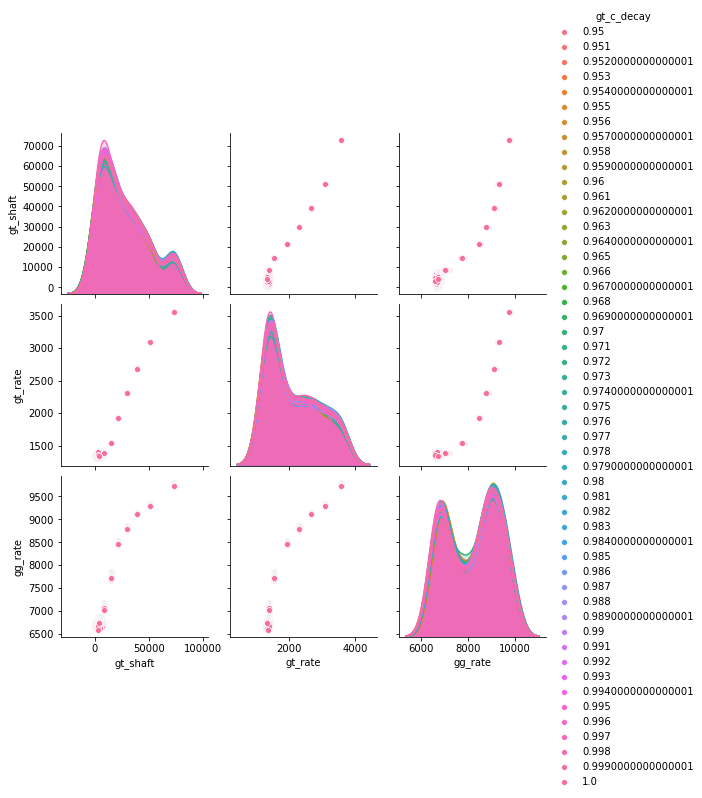

In [14]:
sns.pairplot(data.iloc[:, [2, 3, 4, 14]], hue='gt_c_decay')

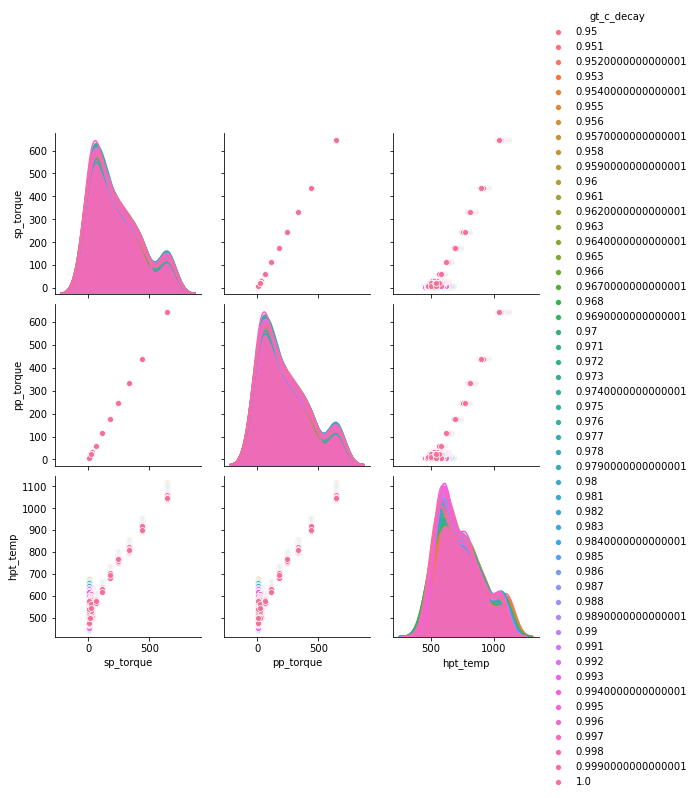

In [15]:
sns.pairplot(data.iloc[:, [5, 6, 7, 14]], hue='gt_c_decay')

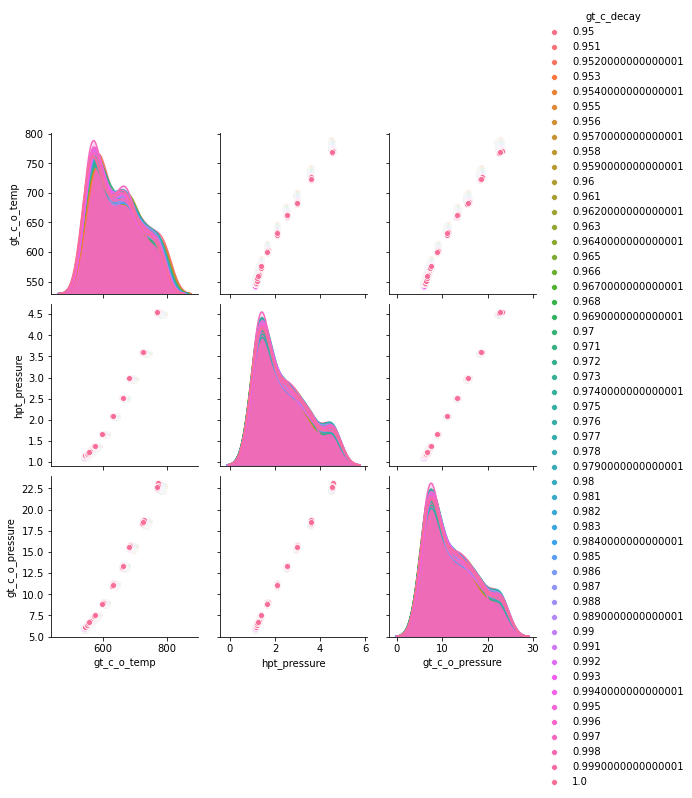

In [16]:
sns.pairplot(data.iloc[:, [8, 9, 10, 14]], hue='gt_c_decay')

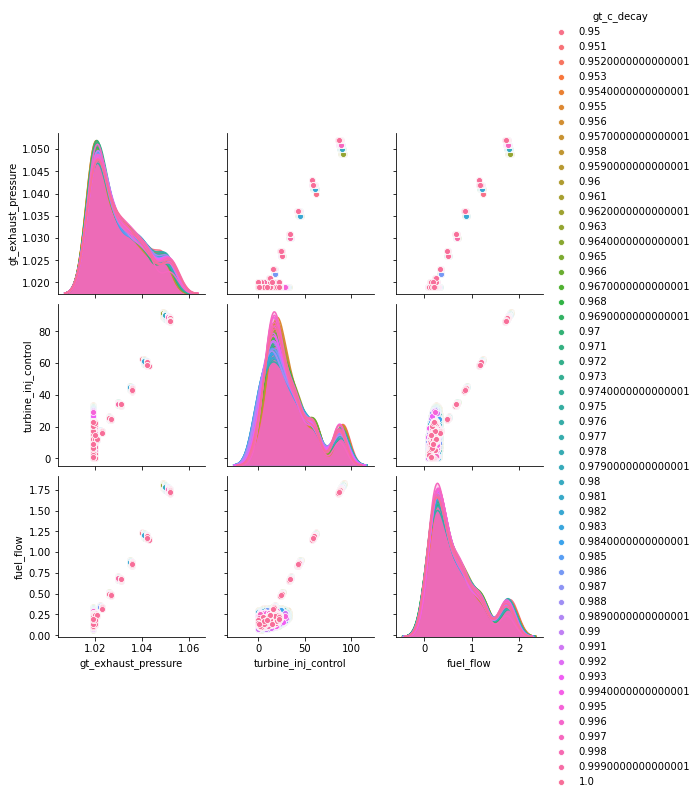

In [17]:
sns.pairplot(data.iloc[:, [11, 12, 13, 14]], hue='gt_c_decay')

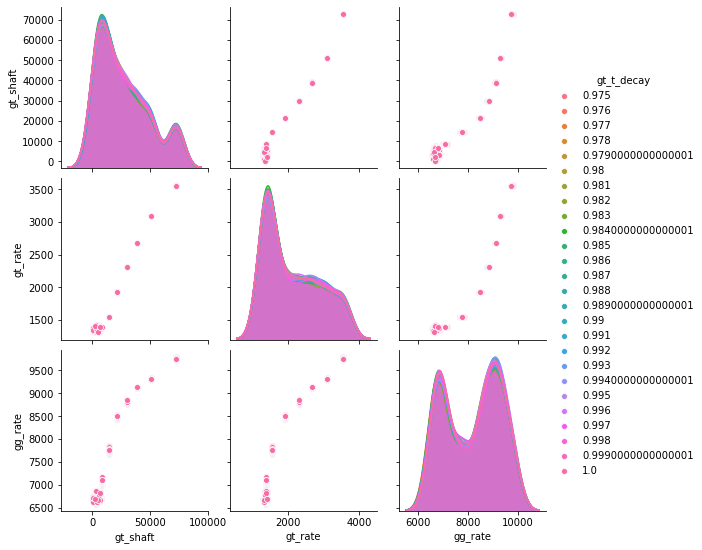

In [18]:
sns.pairplot(data.iloc[:, [2, 3, 4, 15]], hue='gt_t_decay')

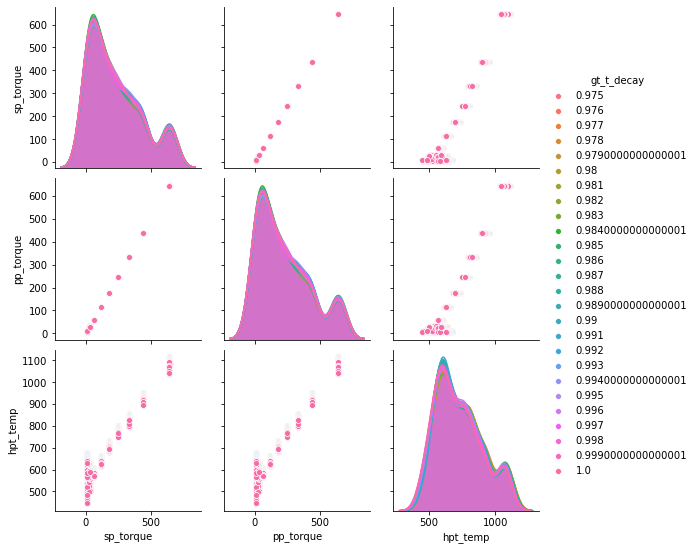

In [19]:
sns.pairplot(data.iloc[:, [5, 6, 7, 15]], hue='gt_t_decay')

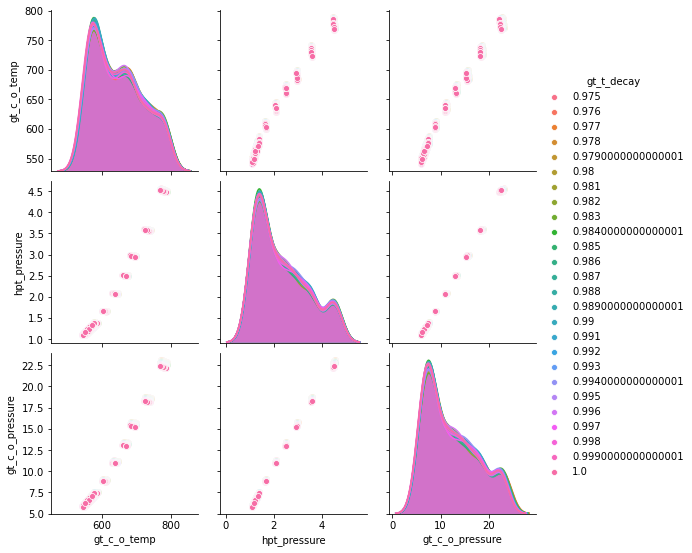

In [20]:
sns.pairplot(data.iloc[:, [8, 9, 10, 15]], hue='gt_t_decay')

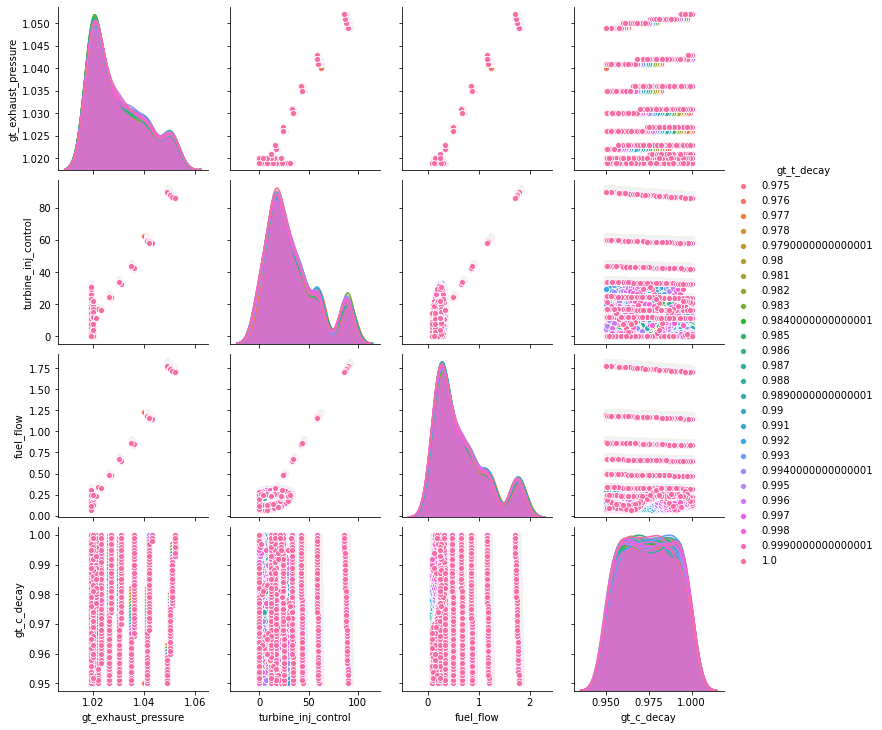

In [21]:
sns.pairplot(data.iloc[:, [11, 12, 13, 14, 15]], hue='gt_t_decay')

In [22]:
#splitting
data2=data
X = data2.iloc[:, 0:14]
y= data2.iloc[:, 14] #GT Compressor decay state coefficient
y2=data2.iloc[:, 15] #GT Turbine decay state coefficient

# Feature selection

In [23]:
# feature selection for GT compressor decay state coefficient
X_train, X_test, y_train1, y_test1 = train_test_split(X, y, test_size=0.20, 
                                                      random_state=0)

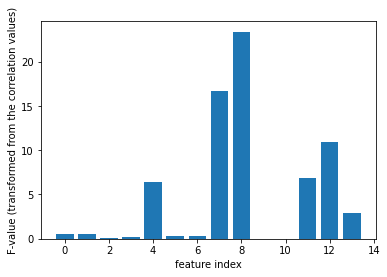

In [24]:
f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train1)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
X_test_fs = f_selector.transform(X_test)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()
# The top selected features for GT compressor decay state coefficient are 7 8 12 11 and 4 

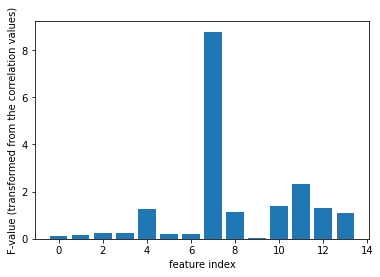

In [25]:
# feature selection for GT Turbine decay state coefficient
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, test_size=0.20, 
                                                      random_state=0)

f_selector = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train2)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
X_test_fs = f_selector.transform(X_test)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("F-value (transformed from the correlation values)")
plt.show()
#The top selected features for GT Turbine decay state coefficient are 7 11 10 12 and 4

#### I have evaluated the models with the selected features, but the error was increasing instead of decreasing. Hence I decided to keep all the features in the final model as it gives comparatively less error.

# Model building

### Models for GT Compressor decay state coefficient

In [26]:
def reg_model(model):
    regressor=model
    regressor.fit(X_train, y_train1)
    y_pred=regressor.predict(X_test)
    r2_s=r2_score(y_test1, y_pred)
    mse=mean_squared_error(y_test1, y_pred)
    rmse=np.sqrt(mse)
    print(model)
    print("r2 score:", r2_s)
    print("rmse score:", rmse)
    return

reg_model(RandomForestRegressor(n_estimators=100, random_state=42)) 
reg_model(DecisionTreeRegressor())
reg_model(LinearRegression())
reg_model(SVR(kernel = 'rbf')) 

RandomForestRegressor(random_state=42)
r2 score: 0.9951821968496893
rmse score: 0.0010359816359376294
DecisionTreeRegressor()
r2 score: 0.9892826277025326
rmse score: 0.0015451537140362458
LinearRegression()
r2 score: 0.8493101606544052
rmse score: 0.005793880270811695
SVR()
r2 score: -1.5363437355642162e-06
rmse score: 0.014925464816882596


### Models for GT Turbine decay state coefficient

In [27]:
def reg_model(model):
    regressor=model
    regressor.fit(X_train, y_train2)
    y_pred=regressor.predict(X_test)
    r2_s=r2_score(y_test2, y_pred)
    mse=mean_squared_error(y_test2, y_pred)
    rmse=np.sqrt(mse)
    print(model)
    print("r2 score:", r2_s)
    print("rmse score:", rmse)
    return

reg_model(RandomForestRegressor(n_estimators=500, random_state=42)) 
reg_model(DecisionTreeRegressor())
reg_model(LinearRegression())
reg_model(SVR(kernel = 'rbf'))

RandomForestRegressor(n_estimators=500, random_state=42)
r2 score: 0.9902507084289445
rmse score: 0.0007480542333277619
DecisionTreeRegressor()
r2 score: 0.9655298682319758
rmse score: 0.001406591625170578
LinearRegression()
r2 score: 0.9152803404113461
rmse score: 0.002205152639844628
SVR()
r2 score: -2.582428749731136e-05
rmse score: 0.007576212774203227


### Creating an ANN for GT Compressor decay state coefficient

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train, y_train1, batch_size = 32, epochs = 100)
y_pred = ann.predict(X_test)

gtcc_ann_mse = mean_squared_error(y_test1, y_pred)
gtcc_ann_rmse = np.sqrt(gtcc_ann_mse)
gtcc_ann_mse = (y_test1, y_pred)
gtcc_ann_r2_score = r2_score(y_test1, y_pred)
print('GTCC mean square error:', gtcc_ann_mse)
print('GTCC root mean square error:', gtcc_ann_rmse)
print('GTCC R2 score:', gtcc_ann_r2_score)

### Creating an ANN for predicting GT Turbine decay state coefficient

In [ ]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train, y_train2, batch_size = 32, epochs = 100)
y_pred = ann.predict(X_test)

gttc_ann_mse = mean_squared_error(y_test2, y_pred)
gttc_ann_rmse = np.sqrt(gttc_ann_mse)
gttc_ann_mse = (y_test2, y_pred)
gttc_ann_r2_score = r2_score(y_test2, y_pred)
print('GTTC mean square error:', gttc_ann_mse)
print('GTTC root mean square error:', gttc_ann_rmse)
print('GTTC R2 score:', gttc_ann_r2_score)

### Here too the Random forest shines as the best model as it gives highest R2 score and lowest RMSE. Hence I have used it in the application, as it outperforms the ANN too!